# Deep Learning laboratory

authors : Laëtitia KANG 245512, Alex ZHANG 245514

## Autoencoders

The goal of the laboratory is to train an autoencoder model for the problem of anomaly detection in image texture.

### Dataset preparation

*  Collect the texture images from a resource indicated by the teacher.
*  Unzip the downloaded archive.
*  Write a python code to randomly crop image patches from all provided full-sized images. Also perform the following augmentations:
    - Patch size = 128 x 128 pixels
    - Random vertical and horizontal flip
    - Random brightness and contrast alteration
    - Random Gamma correction
    
    **For grade 5**. Add random rotation within the limit of 10 degrees, but make sure that the final image patch is 128 x 128 and does not contain zero-valued background.
    
*  Using the above sequence of augmentations, generate a set of 400 images. Partition the cropped and augmented image tiles into training (80%) and test (20%) sets and store them in separate folders.
*  Consider using the Albumentations library for performing the augmentations: https://albumentations.ai/

In [5]:
import random
import numpy as np

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch_directml
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

from sklearn.model_selection import train_test_split

import albumentations as A

import os

In [6]:
def visualize(image):
    plt.figure(figsize=(5, 5))
    plt.axis('off')
    plt.imshow(image,cmap="gray")

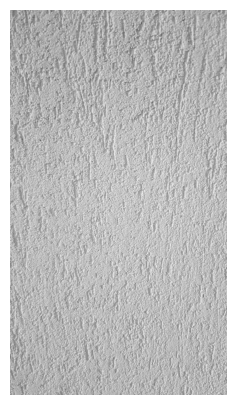

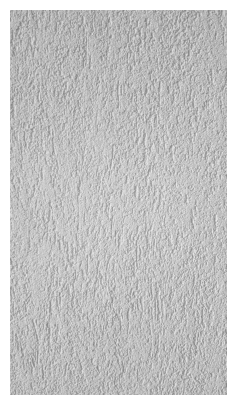

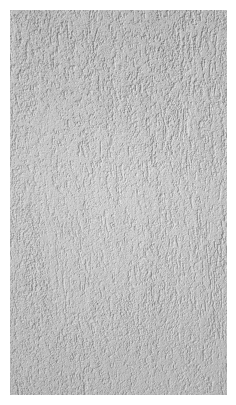

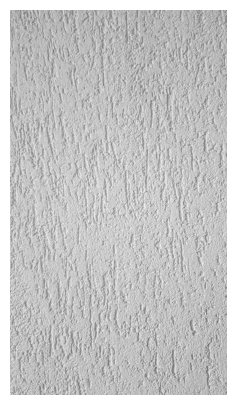

In [7]:
paths = ['20210329_084503.jpg','20210329_084510.jpg','20210329_084516.jpg','20210329_084557.jpg']
images = list()

for file in paths:
    image = cv2.imread(f'images/'+file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    visualize(image)
    images.append(image)
    

In [8]:
transforms = A.Compose([
            A.ShiftScaleRotate(rotate_limit=10),
            A.RandomCrop(width=128, height=128),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.RandomGamma(p=0.5)
        ])


In [9]:
images_ds = list()

for img in images:
    for i in range(100):
        image = transforms(image=img)['image']
        images_ds.append(image)

In [10]:
random.shuffle(images_ds)

In [11]:
images_train = images_ds[:320]
images_test = images_ds[320:]

for k in range(len(images_train)):
    img = images_train[k]
    # save image
    cv2.imwrite(f'./images/images_train/{k}.png',img)

for k in range(len(images_test)):
    img = images_test[k]
    # save image
    cv2.imwrite(f'./images/images_test/{k+len(images_train)}.png',img)

### Model implementation

*  Create a model of the autoencoder of the following architecture.
   - Encoder:
       * 2D convolutional layer with kernel size 3 x 3, stride 2, output channels = 16
       * ReLU activation layer
       * 2D convolutional layer with kernel size 3 x 3, stride 2, output channels = 32
       * ReLU activation layer
       * 2D batch normalization layer
       * 2D convolutional layer with kernel size 3 x 3, stride 2, output channels = 64
       * ReLU activation layer
       * Linear (dense) layer with 128 neurons
       * ReLU activation layer
       * Linear (dense) layer with 64 neurons
       * ReLU activation layer
    - Decoder:
       * Linear (dense) layer with 128 neurons
       * ReLU activation layer
       * Linear (dense) layer with 16 x 16 x 64 neurons
       * ReLU activation layer
       * 2D transpose convolution with kernel size 3 x 3, stride 2, output channels = 32
       * ReLU activation layer
       * 2D transpose convolution with kernel size 3 x 3, stride 2, output channels = 16
       * ReLU activation layer
       * 2D transpose convolution with kernel size 3 x 3, stride 2, output channels = 1
        
**Note 1.** In all convolutional layers of the encoder, adjust padding to ensure that the output feature maps have resolution that is exactly two times lower than the input maps.

**Note 2.** In all convolutional layers of the decoder, adjust padding to ensure that the output feature maps have resolution that is exactly two times higher than the input maps.

**Note 3.** Output of the 3rd convolutional layer must be flattened before passing to the first linear layer.

**Note 4.** Output of the 2nd linear layer must be unflattened before passing to the first deconvolutional layer.
        
**Note 5.** Consider implementing the model in PyTorch. Simple Autoencoder class is presented, e.g. at https://github.com/E008001/Autoencoder-in-Pytorch.

In [15]:
def select_device(device=''):
    if device.lower() == 'cuda':
        if not torch.cuda.is_available():
            print ("torch.cuda not available")
            return torch.device('cpu')    
        else:
            return torch.device('cuda:0')
    if device.lower() == 'dml':
        return torch_directml.device(torch_directml.default_device())
    else:
        return torch.device('cpu')

In [45]:
class Autoencoder(nn.Module):
    
    

    def __init__(self):
        super(Autoencoder, self).__init__()

        dml = select_device('dml')

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), #input size : 128x128 - output size : 64x64
            nn.ReLU(), 
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), #input size : 64x64 - output size : 32x32
            nn.ReLU(),
            nn.BatchNorm2d(32), # no change in size
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), #input size : 32x32 - output size : 16x16
            nn.ReLU(),
            nn.Flatten(), # Output size: 64 x 16 x 16
            nn.Linear(64*16*16, 128), # output size : 128
            nn.ReLU(),
            nn.Linear(128, 64), # output size 64
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 64*16*16),
            nn.ReLU(),
            nn.Unflatten(1, (64, 16, 16)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        )

        self.encoder = self.encoder.to(dml)
        self.decoder = self.decoder.to(dml)

    def forward(self, x):
        dml = select_device('dml')
        x = x.to(dml)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


### Training loop

Write a python script which contains:
  - code to create the autoencoder network object
  - optimizer initialization
  - the training loop
  - a function to load all texture image tiles and store them in a the training and test list
  - a function to sample a random training batch from the list of training tiles

In [221]:
def load_texture_tiles(len_dataset, train_size):
    assert train_size <= 1 and train_size >= 0
    assert isinstance(len_dataset, int)

    # Initialize train and test sets
    train_img = []
    test_img = []

    # Create train set
    len_train_set = int(len_dataset * train_size)
    for img in range(len_train_set):
        image_path = f'images/images_train/{img}.png'
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                image = np.expand_dims(image, axis=0)  # Add channel dimension
                train_img.append(image)

    # Create test set
    for img in range(len_train_set,len_dataset):
        image_path = f'images/images_test/{img}.png'
        if os.path.exists(image_path):
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                image = np.expand_dims(image, axis=0)  # Add channel dimension
                test_img.append(image)

    # Convert list into array
    train_img = np.asarray(train_img)
    test_img = np.asarray(test_img)

    # Convert array into tensor
    train_img = torch.from_numpy(train_img).type(torch.float)
    test_img = torch.from_numpy(test_img).type(torch.float)

    return  train_img, test_img


In [47]:
# Initialize autoencoder network
net = Autoencoder()

# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001) #torch.optim.Adam(auto_encoder.parameters(), lr=1e-4)

In [263]:
train_imgs, test_imgs = load_texture_tiles(400,0.8)

In [49]:
def sample_batch(data, batch_size):
    indices = torch.randperm(data.shape[0])[:batch_size]
    return data[indices]

In [50]:
from tqdm import tqdm
from IPython.display import clear_output

def train_batch(input_data,
                auto_encoder,
                optimizer,
                device = 'cpu',
                nb_epochs=10_000,
                batch_size=128):
    
    
    # Choose device : torch_directml.device()
    device = select_device(device)

    # Create a test_sample that will be actualized at each iteration
    test_sample = sample_batch(input_data, 1)

    # Training Loop
    training_loss = []
    for epoch in tqdm(range(nb_epochs)):
        image_batch = sample_batch(input_data, batch_size)
        x_hat = auto_encoder(image_batch)
        loss = nn.MSELoss()(image_batch.to(device), x_hat.to(device))
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        training_loss += [loss.item()]
        
        
        
        # Print the reconstructed image
        if epoch % 100 == 0:
            # Convert tensor to numpy array and reshape
            image_sample = test_sample[0].squeeze().cpu().data.numpy()
            reconstruction = auto_encoder(test_sample).squeeze().cpu().data.numpy()
            
            # Clear the current output
            clear_output(wait=True)

            # Create a new figure
            fig, axes = plt.subplots(1, 2, figsize=(10, 4))

            # Plot the original image
            axes[0].imshow(image_sample, cmap='gray')
            axes[0].axis('off')
            axes[0].set_title('Original Image')

            # Plot the reconstructed image
            axes[1].imshow(reconstruction, cmap='gray')
            axes[1].axis('off')
            axes[1].set_title(f'Reconstructed Image (epoch={epoch})')

            plt.tight_layout()
            plt.show()
          
    return training_loss

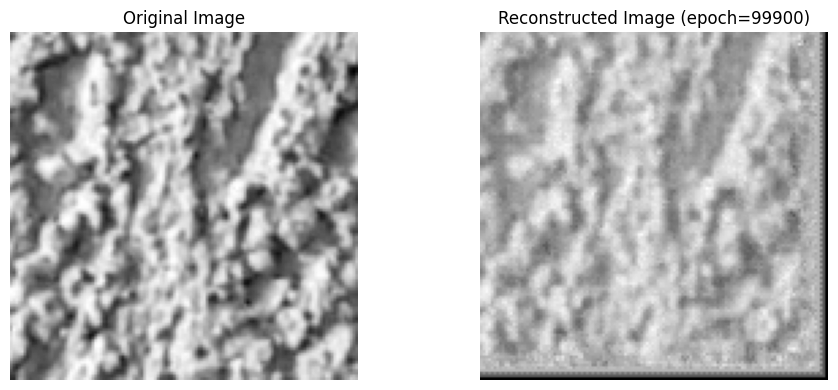

100%|██████████| 100000/100000 [3:28:31<00:00,  7.99it/s]


In [51]:
training_loss = train_batch(train_imgs, net, optimizer,device='dml',nb_epochs=100_000, batch_size=32)

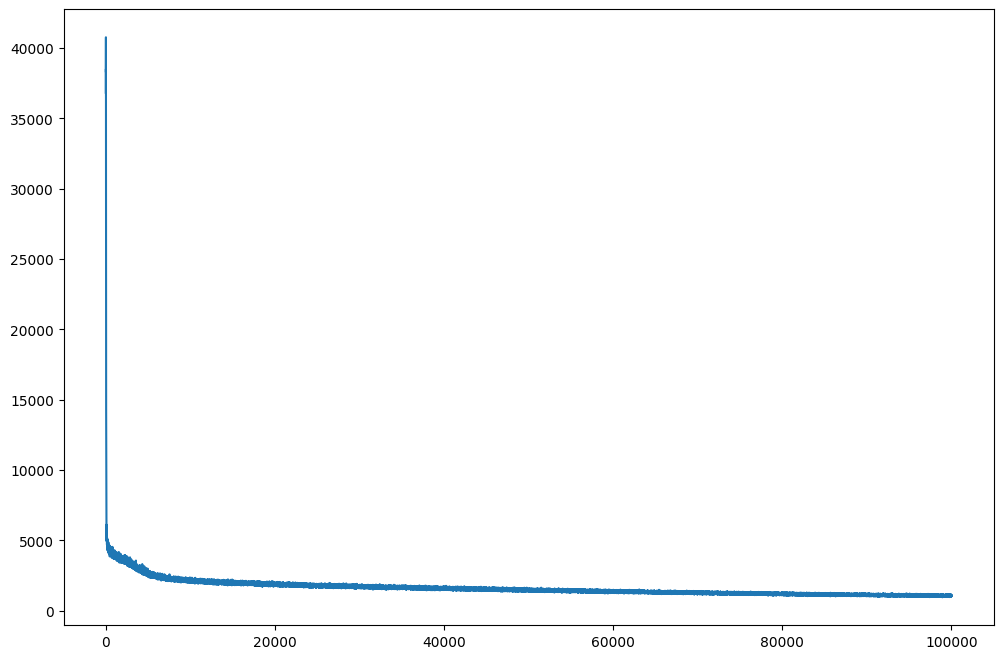

In [52]:
plt.figure(figsize=(12,8))
plt.plot(training_loss)

Write a test routine with:
  - visualization of a sample of reconstructed images randomly picked from the test list
  - a function to randomly apply to a test image tile a distortion effect, e.g.:
      * Sun flare 
      * Grid shuffle
      * Spatter
      
Analyze the loss (mean squared error) obtained for the distorted images in relation to the loss of undistorted images.

**For grade 5** Perform statistical analysis showing the effectiveness of the designed Autoencoder network in the anomaly detection problem.

In [223]:
# Function to visualize reconstructed images
def visualize_reconstructed_images(model, test_images, title, num_samples=5):
    # Randomly select samples from the test set
    sample_indices = random.sample(range(len(test_images)), num_samples)
    samples = test_images[sample_indices]

    # Reconstruct the samples using the model
    reconstructed_samples = model(samples)

    # Plot the original and reconstructed samples
    fig, axes = plt.subplots(2, 5, figsize=(10, 4))
    fig.suptitle(f'Cropped Random Image Tiles from {title}', fontsize=14)

    for i in range(5):
        imgs = samples[i]
        rec_imgs = reconstructed_samples[i]
        axes[0, i].imshow(imgs.squeeze(), cmap='gray')
        axes[1, i].imshow(rec_imgs.squeeze().detach().cpu().numpy(), cmap='gray')  # Detach tensor and convert to NumPy array

    for ax in axes.flatten():
        ax.axis('off')

    plt.show()



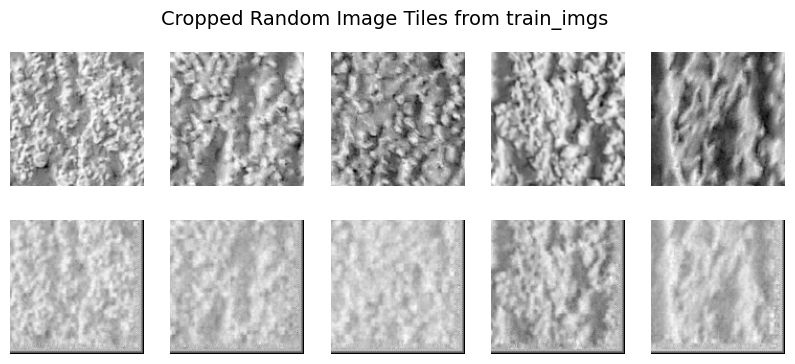

In [224]:
# Visualize reconstructed images from train_img
visualize_reconstructed_images(net, train_imgs, 'train_imgs')

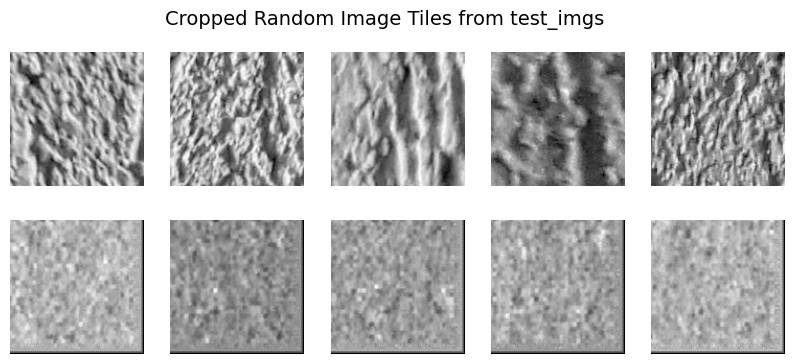

In [225]:
# Visualize reconstructed images from train_img
visualize_reconstructed_images(net, test_imgs, 'test_imgs')

**Remarks :** the model does not perform well. Indeed, the model can reconstruct images from the training set but not from the test set. Either it is **overfitted**, or the model needs more training, so an increase of the number of epochs or the training data. Also the outlines/edges on the right and bottom side of the reconstructed images distort the results.

In [270]:
import copy

def apply_distortion(image, distortion_type):
    if distortion_type == 'sun_flare':
        # Apply sun flare effect
        # Placeholder code: Add a random sun flare pattern to the image
        sun_flare_pattern = np.random.rand(*image.shape)  # Generate a random pattern
        distorted_image = image + sun_flare_pattern

    elif distortion_type == 'grid_shuffle':
        # Apply grid shuffle effect
        # Placeholder code: Shuffle the pixels in a grid pattern
        distorted_image = copy.deepcopy(image)
        grid_size = 8
        for i in range(0, image.shape[0], grid_size):
            for j in range(0, image.shape[1], grid_size):
                distorted_image = distorted_image[i:i+grid_size, j:j+grid_size]
                np.random.shuffle(distorted_image.flatten())

    elif distortion_type == 'spatter':
        # Apply spatter effect
        # Placeholder code: Add random spatter noise to the image
        distorted_image = image + np.random.normal(0, 0.1, size=image.shape)

    else:
        print("Invalid distortion type.")
        return None

    return distorted_image


In [271]:
from sklearn.metrics import mean_squared_error

def apply_distortion_effects(autoencoder_model, test_images):
    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 4))

    # Select a random test image
    random_index = random.randint(0, len(test_images)-1)
    test_image = test_images[random_index]
    
    axes[0,0].imshow(test_image.cpu().squeeze(), cmap='gray')
    axes[0,0].set_title('Original')
    axes[0,0].axis('off')

    test_image = test_image.reshape((1,1,128,128))
    reconstructed_test_image = autoencoder_model(test_image)
    axes[1,0].imshow(reconstructed_test_image.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[1,0].set_title('Reconstructed Original')
    axes[1,0].axis('off')

    

    # Apply distortion effects
    distorted_image_sun_flare = np.asarray(apply_distortion(test_image, 'sun_flare'))
    distorted_image_sun_flare = torch.from_numpy(distorted_image_sun_flare).type(torch.float)
    distorted_image_grid_shuffle = np.asarray(apply_distortion(test_image, 'grid_shuffle'))
    distorted_image_grid_shuffle = torch.from_numpy(distorted_image_grid_shuffle).type(torch.float)
    distorted_image_spatter = np.asarray(apply_distortion(test_image, 'spatter'))
    distorted_image_spatter = torch.from_numpy(distorted_image_spatter).type(torch.float)

    
    # Reconstruct the distorted images using the model
    reconstructed_sun_flare = autoencoder_model(distorted_image_sun_flare)
    reconstructed_grid_shuffle = autoencoder_model(distorted_image_grid_shuffle)
    reconstructed_spatter = autoencoder_model(distorted_image_spatter)

    # Plot the original and distorted images
    axes[0,1].imshow(distorted_image_sun_flare.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[0,1].set_title('Sun Flare')
    axes[0,1].axis('off')

    axes[0,2].imshow(distorted_image_grid_shuffle.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[0,2].set_title('Grid Shuffle')
    axes[0,2].axis('off')

    axes[0,3].imshow(distorted_image_spatter.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[0,3].set_title('Spatter')
    axes[0,3].axis('off')

    # Plot the reconstructed original and distorted images
    axes[1,1].imshow(reconstructed_sun_flare.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[1,1].set_title('Reconstructed Sun Flare')
    axes[1,1].axis('off')

    axes[1,2].imshow(reconstructed_grid_shuffle.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[1,2].set_title('Reconstructed Grid Shuffle')
    axes[1,2].axis('off')

    axes[1,3].imshow(reconstructed_spatter.cpu().squeeze().detach().numpy(), cmap='gray')
    axes[1,3].set_title('Reconstructed Spatter')
    axes[1,3].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate the MSE for distorted and undistorted images
    mse_undistorted = mean_squared_error(test_image.cpu().numpy().flatten(), test_image.detach().cpu().numpy().flatten())
    mse_sun_flare = mean_squared_error(test_image.cpu().numpy().flatten(), reconstructed_sun_flare.detach().cpu().numpy().flatten())
    mse_grid_shuffle = mean_squared_error(test_image.cpu().numpy().flatten(), reconstructed_grid_shuffle.detach().cpu().numpy().flatten())
    mse_spatter = mean_squared_error(test_image.cpu().numpy().flatten(), reconstructed_spatter.detach().cpu().numpy().flatten())

    print("MSE (Undistorted):", mse_undistorted)
    print("MSE (Sun Flare):", mse_sun_flare)
    print("MSE (Grid Shuffle):", mse_grid_shuffle)
    print("MSE (Spatter):", mse_spatter)

C:\Users\Hoover48\AppData\Local\Temp\ipykernel_11548\722548151.py:18: UserWarning: you are shuffling a 'Tensor' object which is not a subclass of 'Sequence'; `shuffle` is not guaranteed to behave correctly. E.g., non-numpy array/tensor objects with view semantics may contain duplicates after shuffling.
  np.random.shuffle(distorted_image.flatten())


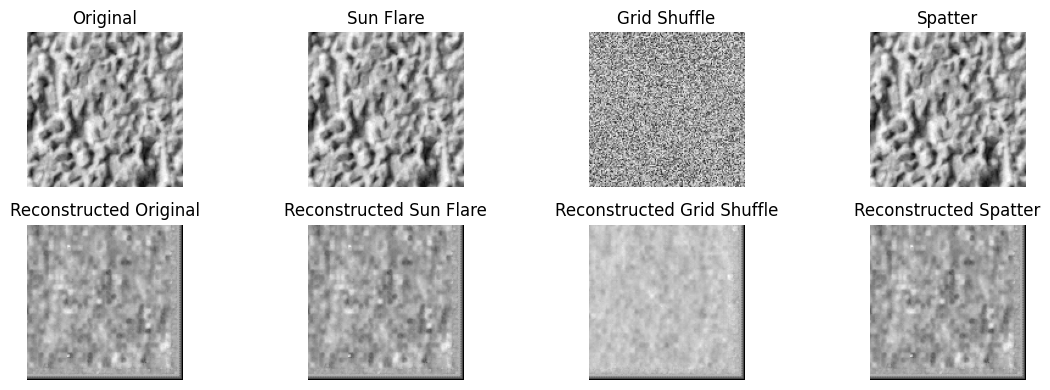

MSE (Undistorted): 0.0
MSE (Sun Flare): 2342.982
MSE (Grid Shuffle): 2681.6133
MSE (Spatter): 2344.2551


In [274]:
apply_distortion_effects(net, test_imgs)

### Report

The report should contain:

*  Visualization of cropped image tiles from the training and test set.
*  Full code of the network architecture.
*  Code of the training loop.
*  Example of distorted images.
*  Comparison of the MSE obtained for the reconstructed images with and without distortions.